In [1]:
# Load environment variables
import os
from dotenv import load_dotenv
load_dotenv()
IMAGES_PATH = os.getenv('IMAGES_PATH')
ROOT_DATA_PATH = os.getenv('ROOT_DATA_PATH')
BATCH_SIZE= int(os.getenv('BATCH_SIZE'))
EPOCHS = int(os.getenv('EPOCHS'))
LR = float(os.getenv('LR'))
PATCH_SIZE=int(os.getenv('PATCH_SIZE'))
DROPOUT=float(os.getenv('DROPOUT'))
ATTENTION_DROPOUT=float(os.getenv('ATTENTION_DROPOUT'))
HIDDEN_DIM=int(os.getenv('HIDDEN_DIM'))
MLP_DIM=int(os.getenv('MLP_DIM'))
NUM_HEADS=int(os.getenv('NUM_HEADS'))
NUM_LAYERS=int(os.getenv('NUM_LAYERS'))


In [2]:
from preprocess.data_process import get_dataloaders

train_loader, val_loader, test_loader = get_dataloaders()

Train Set Size: 6000
Val Set Size: 200
Test Set Size: 500


In [3]:
import torch
from torchvision.models import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(image_size=80, patch_size=PATCH_SIZE, num_layers=NUM_LAYERS, 
                                       num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, 
                                       mlp_dim=MLP_DIM, dropout=DROPOUT,
                                       attention_dropout=ATTENTION_DROPOUT,
                                       num_classes=2)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [4]:
from torchinfo import summary

summary(model, input_size=(64, 3, 80, 80), device='cuda')

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [64, 2]                   768
├─Conv2d: 1-1                                 [64, 768, 8, 8]           231,168
├─Encoder: 1-2                                [64, 65, 768]             49,920
│    └─Dropout: 2-1                           [64, 65, 768]             --
│    └─Sequential: 2-2                        [64, 65, 768]             --
│    │    └─EncoderBlock: 3-1                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [64, 65, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [64, 65, 768]             7,087,872
│    └─LayerNorm: 2-3                      

In [5]:
loss_fn_transformer = lambda output, labels: loss_fn(output, torch.nn.functional.one_hot(labels, num_classes=2).float())

In [6]:
from timeit import default_timer as timer
from tqdm import tqdm
from utilities import train_step, val_step
import pandas as pd
import numpy as np
train_start_time = timer()

print(f"Training on Device: {device}")
model.to(device)

train_loss, train_acc = 0, 0
test_loss, test_acc = 0, 0

min_val_loss = np.inf

os.environ["MODEL_TYPE"] = "transformer"

# Create two empty dataframes to store loss and accuracy values
train_metrics = pd.DataFrame(columns=["train_loss", "train_acc"])
val_metrics = pd.DataFrame(columns=["val_loss", "val_acc"])
test_metrics = pd.DataFrame(columns=["test_loss", "test_acc"])
print("-----------Training starting----------")
for epoch in tqdm(range(0, EPOCHS), unit="EPOCHS", desc="Training (with per-epoch validation):"):
    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Train the model
    train_loss, train_acc = train_step(model, loss_fn_transformer, optimizer, device, train_loader)
    train_metrics.loc[epoch, 'train_loss']= train_loss
    train_metrics.loc[epoch, 'train_acc'] = train_acc

    val_loss, val_acc, min_val_loss = val_step(model, loss_fn_transformer, device, min_val_loss, val_loader)
    val_metrics.loc[epoch, 'val_loss'] = val_loss
    val_metrics.loc[epoch, 'val_acc'] = val_acc
print("-----------Training finished----------")

train_end_time = timer()

total_train_time = train_end_time - train_start_time

print(f"Training completed in {total_train_time:.2f} seconds or {total_train_time/60:.2f} minutes")

Training on Device: cuda
-----------Training starting----------


Training (with per-epoch validation)::   0%|          | 0/100 [00:00<?, ?EPOCHS/s]

		Validation Loss Decreased (inf) --->0.586954 	 Saving model


Training (with per-epoch validation)::   1%|          | 1/100 [00:05<09:46,  5.92s/EPOCHS]

		Validation Loss Decreased (0.586954) --->0.534469 	 Saving model


Training (with per-epoch validation)::   2%|▏         | 2/100 [00:11<09:26,  5.78s/EPOCHS]

		Validation Loss Decreased (0.534469) --->0.435259 	 Saving model


Training (with per-epoch validation)::   3%|▎         | 3/100 [00:17<09:21,  5.78s/EPOCHS]

		Validation Loss Decreased (0.435259) --->0.415021 	 Saving model


Training (with per-epoch validation)::   4%|▍         | 4/100 [00:23<09:15,  5.79s/EPOCHS]

		Validation Loss Decreased (0.415021) --->0.275249 	 Saving model


Training (with per-epoch validation)::   5%|▌         | 5/100 [00:28<09:09,  5.78s/EPOCHS]

		Validation Loss Decreased (0.275249) --->0.207363 	 Saving model


Training (with per-epoch validation)::   6%|▌         | 6/100 [00:34<09:04,  5.80s/EPOCHS]

		Validation Loss Decreased (0.207363) --->0.177661 	 Saving model


Training (with per-epoch validation)::   9%|▉         | 9/100 [00:51<08:37,  5.69s/EPOCHS]

		Validation Loss Decreased (0.177661) --->0.129943 	 Saving model


Training (with per-epoch validation)::  10%|█         | 10/100 [00:57<08:40,  5.78s/EPOCHS]

		Validation Loss Decreased (0.129943) --->0.117490 	 Saving model


Training (with per-epoch validation)::  16%|█▌        | 16/100 [01:32<08:00,  5.72s/EPOCHS]

		Validation Loss Decreased (0.117490) --->0.108922 	 Saving model


Training (with per-epoch validation)::  20%|██        | 20/100 [01:55<07:42,  5.78s/EPOCHS]

		Validation Loss Decreased (0.108922) --->0.101877 	 Saving model


Training (with per-epoch validation):: 100%|██████████| 100/100 [09:47<00:00,  5.87s/EPOCHS]

-----------Training finished----------
Training completed in 587.35 seconds or 9.79 minutes


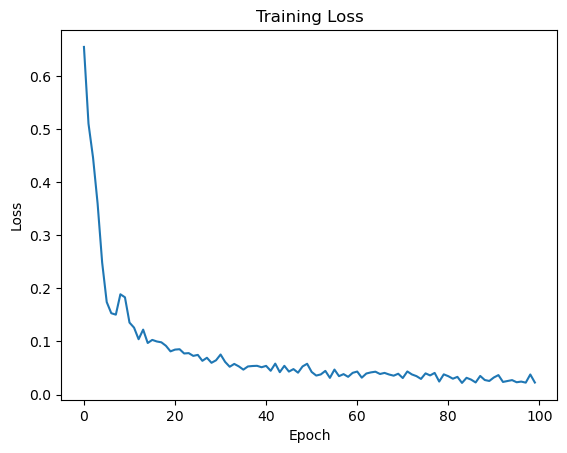

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_metrics['train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

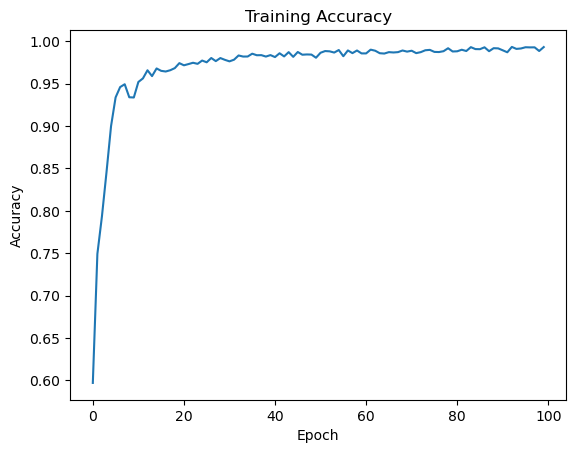

In [8]:
plt.plot(train_metrics['train_acc'])
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show() 

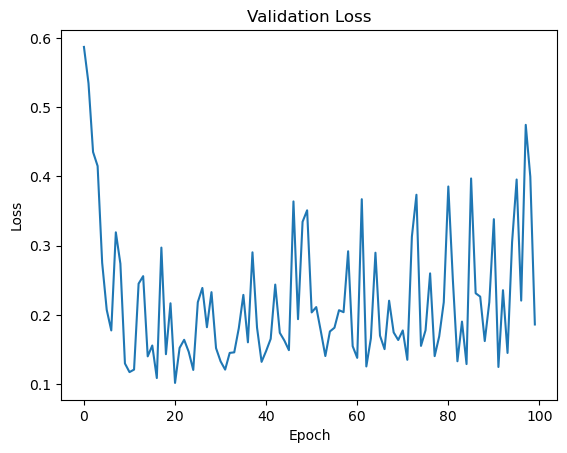

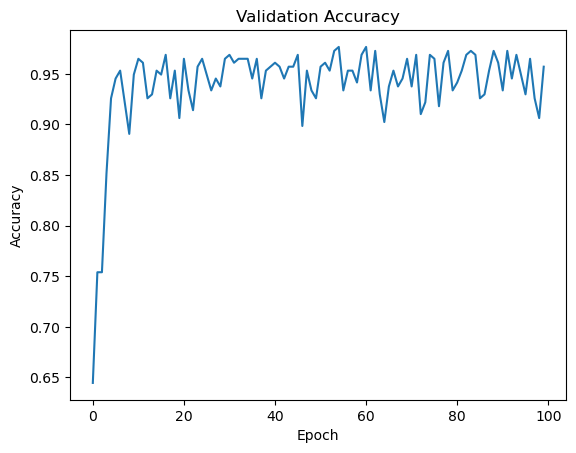

In [9]:
plt.plot(val_metrics['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show() 
plt.plot(val_metrics['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show() 

In [10]:
from utilities import test_step

# Testing
test_start_time = timer()

print("-----------Testing starting----------")

test_results = test_step(model, loss_fn_transformer, device, test_loader, use_tqdm=True)

print("-----------Testing finished----------")

test_end_time = timer()

total_test_time = test_end_time - test_start_time

print(f"Testing completed in {total_test_time:.2f} seconds")

-----------Testing starting----------


Testing: 100%|██████████| 8/8 [00:00<00:00, 52.59batches/s]

-----------Testing finished----------
Testing completed in 0.16 seconds


In [34]:
sample, label = next(iter(test_loader))

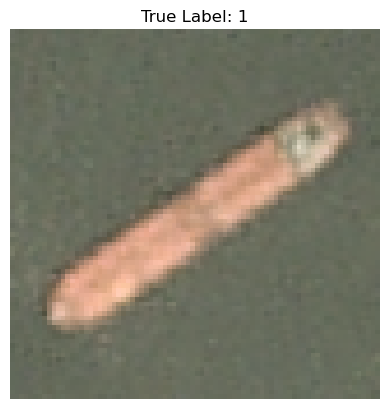

Model Prediction: 1


In [57]:
from torchvision.transforms import v2
import random
transform = v2.Compose([
    v2.ToPILImage()
])
index = random.randint(0, 63)
sample = sample.to(device)
label = label.to(device)
render_sample = transform(sample[index])
model.eval()
plt.imshow(render_sample)
plt.axis("off")
plt.title(f"True Label: {label[index]}")
plt.show()
print(f"Model Prediction: {model(sample)[index].argmax().item()}")

In [33]:
from utilities import save_metrics

# Save metrics
save_metrics(train_metrics, val_metrics, test_results)

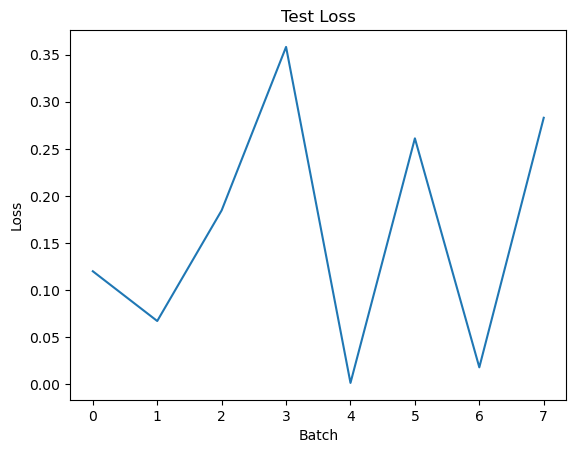

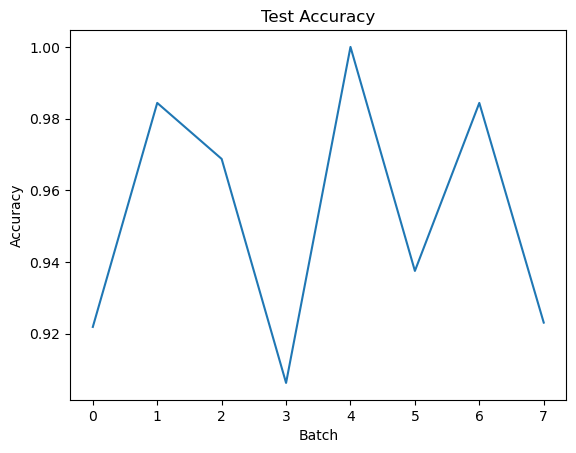

In [11]:
plt.plot(test_results["test_loss"])
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.show() 
plt.plot(test_results['test_acc'])
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')   
plt.show()

In [15]:
print(f"Average Test Loss: {test_results['test_loss'].mean():.4f}")
print(f"Average Test Accuracy: {test_results['test_acc'].mean() * 100:.4f}%")

Average Test Loss: 0.1617
Average Test Accuracy: 95.3275%
